<a href="https://colab.research.google.com/github/olivier2106/SP/blob/master/SPX_predictions_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional , CuDNNLSTM
import math
from sklearn.metrics import mean_squared_error
!pip install pandas-datareader
from pandas_datareader import data as pdr
!pip install fix-yahoo-finance
import fix_yahoo_finance as yf

Using TensorFlow backend.


In [19]:
# First, we get the data
# dataset = pd.DataFrame(data, index_col='Date', parse_dates=['Date'])
# SPX
share = "^GSPC"
dataset = pdr.get_data_yahoo(share)
dataset = dataset.dropna() # removing missing value rows
dataset.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-11-29,3150.300049,3139.340088,3147.179932,3140.979980,1743020000,3140.979980
2019-12-02,3144.310059,3110.780029,3143.850098,3113.870117,3268740000,3113.870117
2019-12-03,3094.969971,3070.330078,3087.409912,3093.199951,3653390000,3093.199951
2019-12-04,3119.379883,3102.530029,3103.500000,3112.760010,3695030000,3112.760010
2019-12-05,3119.429932,3103.760010,3119.209961,3110.909912,693580691,3110.909912


In [0]:
# Checking for missing values
training_set = dataset['2006':'2017'].iloc[:,0:1].values
test_set = dataset['2018':].iloc[:,0:1].values

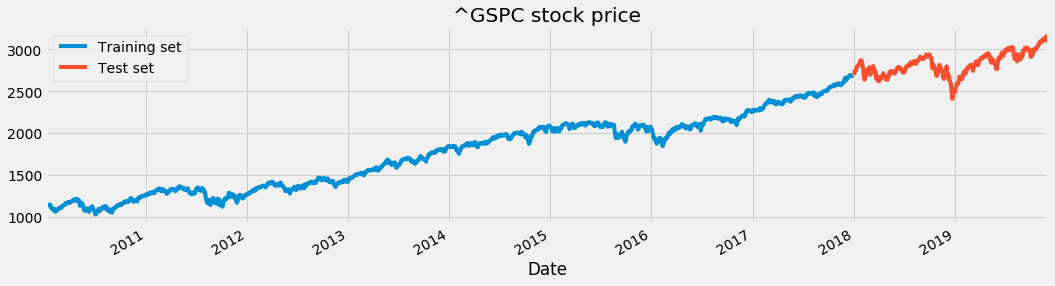

In [21]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"]['2006':'2017'].plot(figsize=(16,4),legend=True)
dataset["High"]['2018':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set','Test set'])
plt.title(share+' stock price')
plt.show()

In [0]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [0]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []

previous = 30

for i in range(previous,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-previous:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [24]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_train.shape

(1983, 30, 1)

In [25]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
1983/1983 [==============================] - 8s 4ms/step - loss: 0.0218
Epoch 2/50
1983/1983 [==============================] - 5s 2ms/step - loss: 0.0043
Epoch 3/50
1983/1983 [==============================] - 5s 2ms/step - loss: 0.0036
Epoch 4/50
1983/1983 [==============================] - 5s 2ms/step - loss: 0.0028
Epoch 5/50
1983/1983 [==============================] - 5s 2ms/step - loss: 0.0024
Epoch 6/50
1983/1983 [==============================] - 5s 2ms/step - loss: 0.0027
Epoch 7/50
1983/1983 [==============================] - 5s 2ms/step - loss: 0.0023
Epoch 8/50
1983/1983 [==============================] - 5s 2ms/step - loss: 0.0022
Epoch 9/50
1983/1983 [==============================] - 5s 2ms/step - loss: 0.0021
Epoch 10/50
1983/1983 [==============================] - 5s 2ms/step - loss: 0.0021
Epoch 11/50
1983/1983 [==============================] - 5s 2ms/step - loss: 0.0020
Epoch 12/50
1983/1983 [==============================] - 5s 2ms/step - loss: 0.0018
E

In [0]:
# testing the model
dataset_total = pd.concat((dataset["High"][:'2017'],dataset["High"]['2018':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - previous:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(previous,len(inputs)):
    X_test.append(inputs[i-previous:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressorGRU.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

[3119.42993164] [2919.8616]


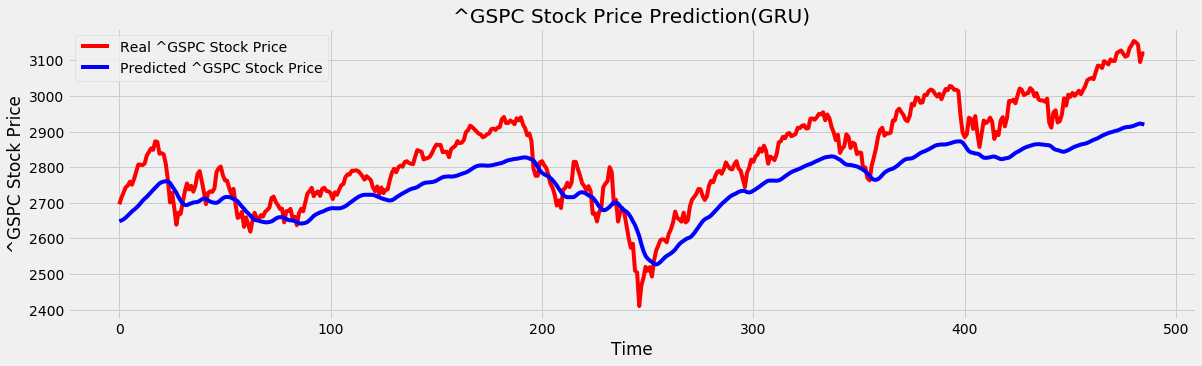

In [28]:
print(test_set[-1],predicted_stock_price[-1])
# Visualizing the results
plt.figure(figsize=(18,5))
plt.plot(test_set[:], color='red',label='Real '+share+ ' Stock Price')
plt.plot(predicted_stock_price[:], color='blue',label='Predicted '+share+' Stock Price')
plt.title(share+' Stock Price Prediction(GRU)')
plt.xlabel('Time')
plt.ylabel(share+' Stock Price')
plt.legend()
plt.show()

In [29]:
# Evaluating our model
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 99.01220225506245.


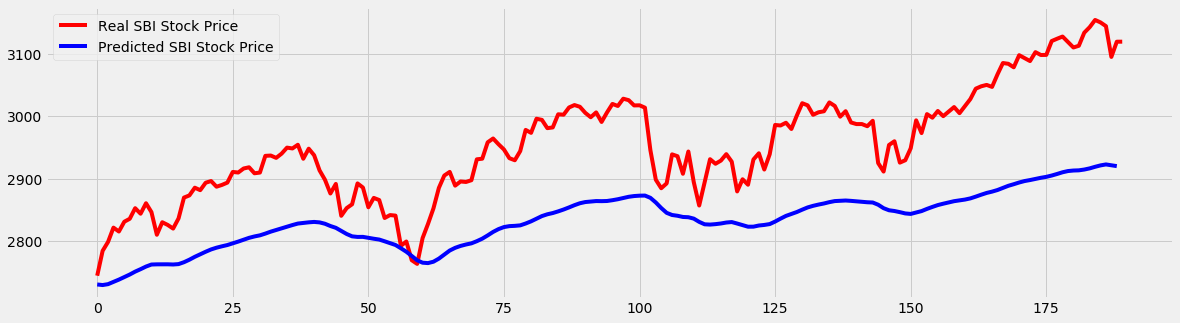

In [30]:
# print("prid",predicted_stock_price[len(predicted_stock_price)-1])
# print("test_set",test_set[len(test_set)-1])
# dataset.tail()

prev = predicted_stock_price[len(predicted_stock_price)-2]
current = predicted_stock_price[len(predicted_stock_price)-1]

diff =  current[0] - prev[0]

_prev = test_set[len(test_set)-2]
_current = test_set[len(test_set)-1]

_diff = _current[0] - _prev[0]


pred = predicted_stock_price
# plt.figure(figsize=(10,5))
plt.figure(figsize=(18,5))
plt.plot(test_set[-190:], color='red',label='Real SBI Stock Price')
plt.plot(predicted_stock_price[-189:], color='blue',label='Predicted SBI Stock Price')
plt.legend()
plt.show()
# print("predicted 1 day ahead",prev,current,diff)
# print("real last",_current,current,_diff)

In [14]:
# just trying
# last_pred = predicted_stock_price
new_pred = []
scaled_t = sc.fit_transform(test_set[-31:-1])
scaled_t = np.array([scaled_t])

p = regressorGRU.predict(scaled_t)

print("last real",sc.inverse_transform(scaled_t[-1]))
print("forcast",sc.inverse_transform(p))

last real [[275.        ]
 [277.79998779]
 [277.6499939 ]
 [284.1499939 ]
 [285.        ]
 [291.        ]
 [317.79998779]
 [315.        ]
 [319.        ]
 [322.        ]
 [318.95001221]
 [323.29998779]
 [321.        ]
 [319.6499939 ]
 [318.6000061 ]
 [309.5       ]
 [323.70001221]
 [329.8500061 ]
 [331.79998779]
 [332.5       ]
 [332.8500061 ]
 [333.79998779]
 [337.5       ]
 [340.        ]
 [345.54998779]
 [351.        ]
 [348.8500061 ]
 [344.3500061 ]
 [342.95001221]
 [342.95001221]]
forcast [[341.8812]]


In [0]:
import time 
